# Hluboké zpětnovazební učení

Dneska se podíváme na hluboké zpětnovazební učení, které kombinuje dva nám už známé přístupy - zpětnovazební učení a hluboké neuronové sítě. Tato technika umožňuje vytváření velmi dovedných agentů, kteří jsou schopni se trénovat jen za pomocí interakcí s prostředím, nebo třeba pouze hraním 'sám se sebou' pro hry jako šachy, go apod. Díky tomu se dokázaly naučit hrát na úrovni lidských hráčů, ba i je překonávat.

In [1]:
from collections import deque, namedtuple
import time

import numpy as np

import tensorflow as tf

# Turns off GPU computation of Tensorflow, when that functionality is installed
# (We are using small networks and small batches, hence the communication overhead
# is much more significant, than the computational boost we gain by utilizing
# the power of the GPU.)
tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt
%matplotlib inline

import gymnasium as gym

## Hluboké Q-učení

Dnes se podíváme na agenta pro hluboké Q-učení, který je podobný klasickému Q-učení, akorát místo matice Q, která si pro každý stav a akci pamatovala očekávanou odměnu, budeme mít neuronovou síť. Implementace je tedy celkem přímočará - musíme agentovi definovat model neuronové sítě, který bude předpovídat hodnoty funkce Q. Na vstupu tedy bude dostávat stav a bude nám vracet ohodnocení všech akcí. (Další možností implementace by mohla být třeba síť, která na vstupu dostane stav a akci a vrací jedno číslo - Q hodnotu pro tento pár stav, akce.)

Protože ale dělat update vah po každém kroku jen v závislosti na datech z toho posledního kroku by vyústilo ve velice nestabilní (a pomalé) trénování, uděláme to chytřeji. Do bufferu (říkáme mu experience nebo replay buffer) si budeme ukládat minulý stav, akci, odměnu, nový stav a informaci, zda šlo o koncový stav (terminated) a po každém kroku si z bufferu vybereme náhodnou trénovací množinu několika minibatchů (často i jen jeden), na jejichž základě upravíme váhy sítě tak, že síť spočítá odměnu pro danou akci a chybu spočítáme pouze druhou mocninou rozdílu odměny od prostředí a odměny od sítě a ta se pak backpropaguje zpátky. Toto za nás běžně udělá metoda `fit`, jen bychom jí museli předat stavy a požadované výstupy, ale v našem případě (pro malé batche a malou síť) by měla zbytečně velký overhead. Proto hrábneme hlouběji do vnitřností tensorflow a použijeme nízkoúrovňové volání, kterým naimplementujeme naše trénování. Požadované výstupy budeme počítat pomocí druhé sítě, která je v podstatě tatáž, jako ta, kterou používáme pro určování nejlepší akce při simulaci a kterou trénujeme (co se architektury týče), ale aktualizuje se jen občas - a to tak, že se do ní zkopírují váhy z naší trénované sítě. To se dělá pro stabilizaci trénování.

In [ ]:
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "terminated"])


class QNetwork:
    def __init__(self, num_inputs, num_outputs, num_hidden_units, learning_rate):
        self._model = tf.keras.models.Sequential([
            tf.keras.layers.Input(num_inputs),
            tf.keras.layers.Dense(num_hidden_units, tf.keras.activations.relu),
            tf.keras.layers.Dense(num_outputs)
        ])
        
        self._model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.MeanSquaredError()
        )


    # Define a training method.
    # (Note that we need to use @tf.function decorator and this custom function for efficiency. 
    # Using `train_on_batch` - or worse, `fit` - on extremely small batches / networks has
    # considerable overhead.)
    @tf.function
    def train(self, states, target_q_values):
        self._model.optimizer.minimize(
            lambda: self._model.compiled_loss(target_q_values, self._model(states, training=True)),
            var_list=self._model.trainable_variables
        )


    # Predict method, again with manual @tf.function for efficiency.
    @tf.function
    def predict(self, states):
        return self._model(states)


    # Predict method, again with manual @tf.function for efficiency.
    @tf.function
    def copy_weights_from(self, other):
        self.soft_update_towards(other, 1.0)


    # The following method copies weights from a given QNetwork to the current one.
    @tf.function
    def soft_update_towards(self, other, update_strength=0.01):
        for var, other_var in zip(self._model.variables, other._model.variables):
            var.assign((1 - update_strength) * var + update_strength * other_var)

In [ ]:
class DeepQLearningAgent:
    def __init__(
        self,
        num_inputs,
        num_outputs,
        num_hidden_units=8,
        learning_rate=1e-2,
        batch_size=32,
        num_batches=1,
        epsilon=1.0,
        epsilon_decay=0.999,
        epsilon_min=0.05,
        gamma=0.99,
        target_model_update_interval=100,
        target_update_strength=1.0 # Soft update is suitable for harder problems, for CartPole we will use hard update
    ):
        self.num_inputs = num_inputs # State size
        self.num_outputs = num_outputs # Number of actions
        self.learning_rate = learning_rate
        
        self.q_network = QNetwork(num_inputs, num_outputs, num_hidden_units, learning_rate)
        self.target_network = QNetwork(num_inputs, num_outputs, num_hidden_units, learning_rate)
        self.target_network.copy_weights_from(self.q_network)
        
        self.replay_buffer = deque(maxlen=100000)
        
        self.batch_size = batch_size
        self.num_batches = num_batches
        
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        
        self.target_model_update_interval = target_model_update_interval
        self.target_update_strength = target_update_strength
        self.update_counter = 0
    
    
    # Save the state, action, reward, next_state and terminated to buffer
    def memorize(self, state, action, reward, next_state, terminated):
        self.replay_buffer.append(Transition(np.array(state), action, reward, np.array(next_state), terminated))
    
    
    # Returns action - in an epsilon-greedy manner when training, otherwise the best predicted
    def action(self, state, train=False):
        if train and np.random.uniform() < self.epsilon:
            return np.random.randint(self.num_outputs)
        else: 
            return np.argmax(self.q_network.predict(np.array(state))[0])


    # Training using the replay buffer
    def train(self):
        # We cannot train when there is not enough data in the replay buffer
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Update the target network, when required
        if self.update_counter >= self.target_model_update_interval:
            self.update_counter = 0
            self.target_network.soft_update_towards(self.q_network, self.target_update_strength)
        
        self.update_counter += 1
        
        for _ in range(self.num_batches):
            # Sample a minibatch from the buffer
            batch_indices = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)
            
            states = np.array([self.replay_buffer[i].state for i in batch_indices])
            next_states = np.array([self.replay_buffer[i].next_state for i in batch_indices])
            actions = np.array([self.replay_buffer[i].action for i in batch_indices])
            rewards = np.array([self.replay_buffer[i].reward for i in batch_indices])
            not_terminations = np.array([not self.replay_buffer[i].terminated for i in batch_indices])
            
            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))
            
            # Predict the Q-values
            predicted = np.array(self.q_network.predict(states))
            next_predicted = np.array(self.target_network.predict(next_states))
                           
            # Compute the target values (using the Bellman equations and target network)
            # (When truncated, we did not reach a final state and the episode would continue to go on -
            # if not for the timestep limit meant only as a way of keeping the episodes reasonably long,
            # so we do treat the state the episode was truncated in as any other state, unlike the state
            # the episode was terminated in, when we do not add the estimate of the future return to the
            # current reward when computing the target Q-value.)
            target_q_values = predicted
            target_q_values[range(target_q_values.shape[0]), actions] = \
                rewards + not_terminations * self.gamma * np.max(next_predicted, axis=-1)

            self.q_network.train(states, target_q_values)
        
        # Lower the epsilon for the epsilon-greedy strategy
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

Tentorkrát si vyzkoušíme prostředí [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/), kde máme tyč na vozíku, který se pohybuje doprava nebo doleva. Cílem je, aby tyč nespadla. Odměna +1 je získána za každý časový krok, kdy tyč zůstane (víceméně) vzpřímená. Epizoda končí, když je tyč více než 12 stupňů od svislé osy, nebo když se vozík posune více než 2,4 jednotky od středu.

In [ ]:
# Create an agent with 4 inputs and 2 actions
agent = DeepQLearningAgent(4, 2)

# Create the environment
env = gym.make("CartPole-v1")

# Train the agent on 200 episodes
returns = []
for i in range(200):
    start = time.time()
    
    observation, _ = env.reset()
    observation = np.reshape(observation, newshape=(1, -1))
    
    done = False # Indicates, whether the current episode ended
    R = 0 # Return for the current episode so far
    t = 0 # Current timestep
    while not done:
        old_state = observation
        
        action = agent.action(observation, train=True)
        observation, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        R += reward
        t += 1
        
        observation = np.reshape(observation, newshape=(1, -1))
        agent.memorize(old_state, action, reward, observation, terminated)
        
        agent.train()
    
    returns.append(R)
    print(f"Iteration {i}: {R} (Duration {time.time() - start:.4f} s)")
    
env.close()

Iteration 0: 77.0 (Duration 0.6250 s)
Iteration 1: 13.0 (Duration 0.0470 s)
Iteration 2: 11.0 (Duration 0.0300 s)
Iteration 3: 10.0 (Duration 0.0250 s)
Iteration 4: 15.0 (Duration 0.0540 s)
Iteration 5: 20.0 (Duration 0.0640 s)
Iteration 6: 15.0 (Duration 0.0480 s)
Iteration 7: 11.0 (Duration 0.0340 s)
Iteration 8: 16.0 (Duration 0.0520 s)
Iteration 9: 11.0 (Duration 0.0260 s)
Iteration 10: 17.0 (Duration 0.0390 s)
Iteration 11: 16.0 (Duration 0.0390 s)
Iteration 12: 13.0 (Duration 0.0310 s)
Iteration 13: 12.0 (Duration 0.0340 s)
Iteration 14: 22.0 (Duration 0.0490 s)
Iteration 15: 14.0 (Duration 0.0310 s)
Iteration 16: 27.0 (Duration 0.0610 s)
Iteration 17: 11.0 (Duration 0.0330 s)
Iteration 18: 41.0 (Duration 0.1380 s)
Iteration 19: 15.0 (Duration 0.0340 s)
Iteration 20: 21.0 (Duration 0.0620 s)
Iteration 21: 53.0 (Duration 0.1290 s)
Iteration 22: 34.0 (Duration 0.0970 s)
Iteration 23: 18.0 (Duration 0.0490 s)
Iteration 24: 13.0 (Duration 0.0350 s)
Iteration 25: 27.0 (Duration 0.0710

Vyzkoušíme, jak dobře náš agent umí problém řešit, a zároveň si i necháme vykreslit animaci.

In [7]:
env = gym.make("CartPole-v1", render_mode="human")

observation, _ = env.reset()
observation = np.reshape(observation, newshape=(1, -1))

done = False # Indicates, whether the current episode ended
R = 0 # Return for the current episode so far
t = 0 # Current timestep
while not done:
    old_state = observation
    
    action = agent.action(observation, train=False)
    observation, reward, terminated, truncated, _ = env.step(action)
    
    done = terminated or truncated
    R += reward
    t += 1
    
    observation = np.reshape(observation, newshape=(1, -1))
    
print(R)
env.close()

500.0


Vykreslíme si výsledný graf odměn. Vidíme, že se celkově výsledky zlepšují, ale občas nám spadnou dolů. To se klidně může stát, protože vykreslujeme skóre z jedné hry a občas holt nějaká nevyjde (třeba kvůli $\epsilon$-greedy strategii, nevýhodnému počátečnímu stavu apod.). Navíc zpětnovazební učení je v obecnosti často křehké (a Deep Q-learning nepatří zrovna k těm nejrobustnějším přístupům - byť naše implementace je rozhodně robustnější, než kdybychom například nepoužívali *target_network*, nebo, nedej bože, *replay_buffer*) a náchylné na perfektně vyladěné nastavení hyperparametrů, takže se i tak může stát, že se občas agent během trénování zhorší, místo aby se stále jen zlepšoval.

Často se tak při zpětnovazebním učení dělá to, že si během tréninku ukládáme náš model. Jedna možnost je ukládat si ho nějakým způsobem pravidelně ve formě checkpointů. Nevýhodou tohoto přístupu ale je, že musíme pro checkpointy mít dost místa na disku a je asi těžké odhadnout, s jakou frekvencí se zrovna vyplatí checkpointy ukládat. Další možností je v každé iteraci zkoumat, zda už náhodou nemáme dost dobré řešení (pokud víme, co to v daném prostředí znamená "dost dobré") a pokud ano, můžeme model uložit a trénování ukončit. Nevýhodou je tentokrát to, že testování, zda je model už dost dobrý, by mělo být nějakým způsobem robustní, tedy nemělo by sestávat jen z jedné episody, abychom neskončili předčasně jen kvůli tomu, že měl nějaký náhodný agent štěstí. A to je časově náročné. Tohle se dá částečně spravit tím, že našeho agenta testujeme jen občas v nějakých intervalech, ale zas nastává problém, jak nastavit délku těchto intervalů. Druhá možnost nápravy je následující: Když to vypadá, že je agent dobrý, tedy jedna celá episoda při trénování dopadla dobře, můžeme agenta otestovat na více episodách, abychom dostali robustní odhad jeho kvalit. (Problémem zde je, když agenta trénujeme při každém kroku, nejen na konci episody - mohli jsme si ho v závěru episody rozbít a budeme ho tak testovat zbytečně, nic z toho nebude. Ale to nám holt jen přidá nějakou časovou náročnost častějším testováním a trénování holt bude pokračovat dál.) Poslední "vylepšení" je pak když pro dané prostředí nevíme, co je "dost dobré", můžeme agenta prostě testovat na to, jestli je lepší než ten předchozí nejlepší. A s trénováním pak pokračovat, dokud nás to baví. A jako vždycky, cokoli, co vymyslíte, by teoreticky mohlo fungovat.

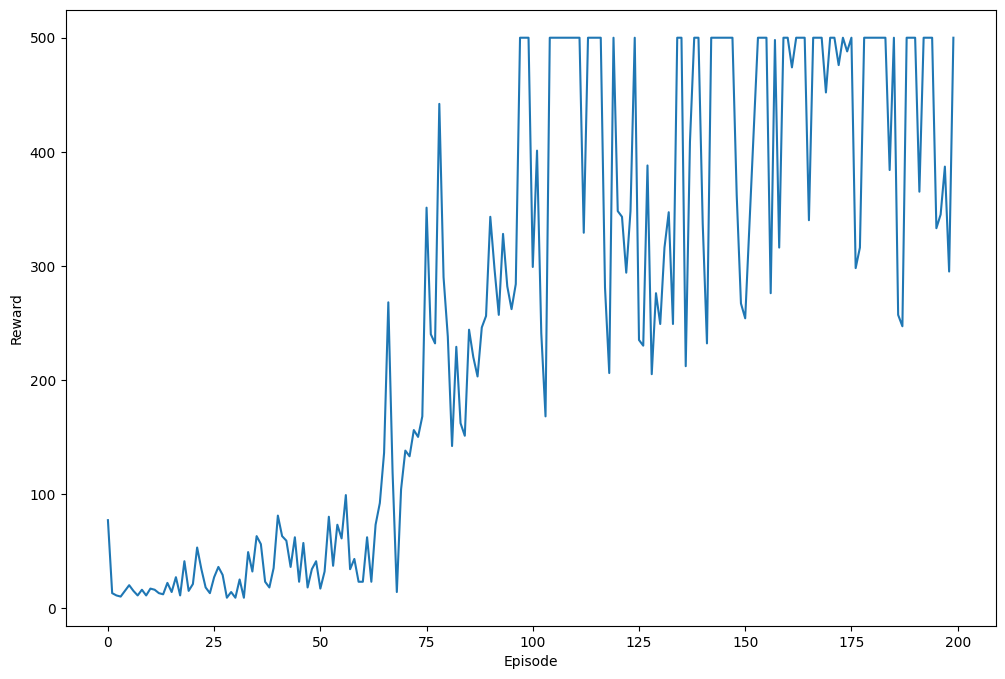

In [6]:
plt.figure(figsize=(12,8))
plt.plot(returns)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

## Úkol na cvičení

Vyberte si z [Gymnasia](https://gymnasium.farama.org/) některý z problémů se spojitými stavy a zkuste ho vyřešit pomocí hlubokého Q-učení. Doporučuji si vybrat nějaké s diskrétními akcemi, nebo klidně i spojité, které bude potřeba diskretizovat, ale těch akcí tam bude málo, aby naše síť nemusela mít moc výstupů a netrénovala se příliš dlouho.

Zkusit případně můžete i implementovat ukládání agenta v průběhu testování některým z výše popsaných způsobů, aby vaše výsledky nebyly tak závislé na štěstí, jestli trénování skončí zrovna v tu pravou chvíli.

Případně můžete vyzkoušet i to, jak by se trénování lišilo, pokud bychom trénovali po každé episodě, namísto po každém kroku. Nezapomeňte ale upravit hyperparametry.